# 2 Data wrangling

## 2.2 Introduction

This step focuses on collecting your data, organizing it, and making sure it's well defined.

### 2.2.1 Recap Of Data Science Problem

The purpose of this data science project is to predict time to failure given each small segment of acoustic signal using a data-driven model

## 2.3 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import numpy as np
import glob, os
pd.set_option("display.precision", 8)

In [2]:
from scipy import signal

## 2.4 Objectives

There are some fundamental questions to resolve in this notebook before you move on.

* Do you think you may have the data you need to tackle the desired question?
    * Have you identified the required target value?
    * Do you have potentially useful features?
* Do you have any fundamental issues with the data?
* Do your column names correspond to what those columns store?
    * Check the data types of your columns. Are they sensible?
    * Calculate summary statistics for each of your columns, such as mean, median, mode, standard deviation, range, and number of unique values. What does this tell you about your data? What do you now need to investigate?

# 2.5 Load the training data

## 2.5.1 Check a small section of data

In [3]:
filename = 'D:/DataScience/rawdata/2ndCapstone/train.csv'

In [4]:
# df_tr_sec =  pd.read_csv(filename,nrows = 6e6)
df_tr_sec =  pd.read_csv(filename,nrows = 150000)


In [5]:
df_tr_sec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   acoustic_data    150000 non-null  int64  
 1   time_to_failure  150000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.3 MB


In [6]:
df_tr_sec.describe()

,acoustic_data,time_to_failure
count,150000.00000000,150000.00000000
mean,4.88411333,1.45018249
std,5.10110613,0.01124842
min,-98.00000000,1.43079719
25%,3.00000000,1.44039789
50%,5.00000000,1.44999858
75%,7.00000000,1.45959928
max,104.00000000,1.46909998


In [7]:
df_tr_sec.head()

,acoustic_data,time_to_failure
0,12,1.46909998
1,6,1.46909998
2,8,1.46909998
3,5,1.46909998
4,8,1.46909998


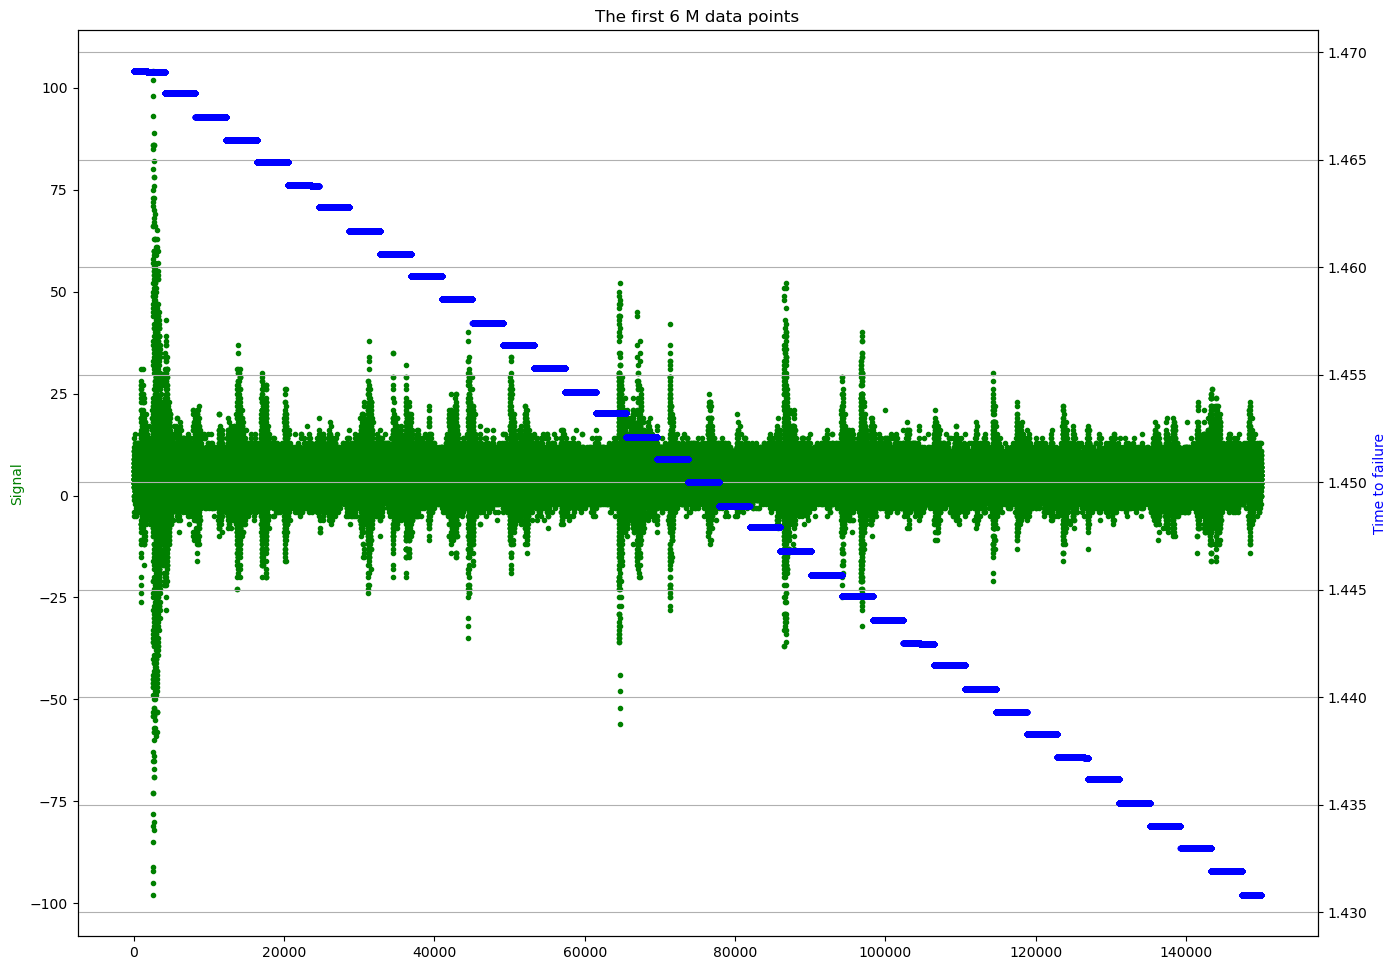

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(16, 12), dpi=100 )
ax2 = ax1.twinx()
ax1.plot(df_tr_sec['acoustic_data'], 'g.')
ax2.plot(df_tr_sec['time_to_failure'], 'b.')


ax1.set_ylabel('Signal', color='g')
ax2.set_ylabel('Time to failure', color='b')
ax2.grid()
plt.title('The first 6 M data points');

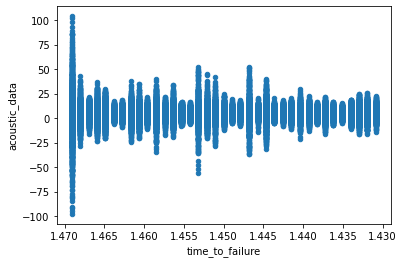

In [9]:
df_tr_sec.plot('time_to_failure','acoustic_data',kind = 'scatter')
plt.gca().invert_xaxis()

1.09999987e-09    64231
1.10000009e-09    59657
1.10000031e-09    18314
1.09999965e-09     7761
1.09549550e-03       17
9.95495500e-04       11
1.09549550e-03        6
9.95495500e-04        2
Name: dt, dtype: int64


C:\anaconda\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\anaconda\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


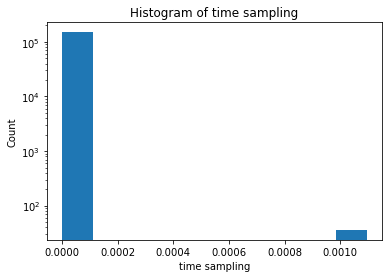

In [10]:
time2fail_np = df_tr_sec['time_to_failure'].to_numpy()
# dt_np = time2fail_np[0:-1] - time2fail_np[1:] 
dt = pd.Series(-df_tr_sec['time_to_failure'].diff(), name='dt')
print(dt.value_counts())
plt.hist(dt.sort_values()[1:])# remove the time difference between two segement, which is about -11
plt.title('Histogram of time sampling')
plt.ylabel('Count')
plt.yscale('log')
plt.xlabel('time sampling');

`acoustic_data` distribute unevenly.

From `time_to_failure`, the equipment may work a while to acquire signal at high frequency (1.1e-9 s), and then take a rest (1e-3 s)before next aquisition.

The sampling rate is not a constant, and the distribution of time step is bimodal with one large timestep and a small timestep.

Try resample with the large timestep later.



## 2.5.2 Resampling the small section of training data

In [11]:
# power spectrum density (square of amplitude spectrum)
def psd(input_signal):
    f, Pxx_den = signal.periodogram(input_signal, fs = 1/1.1e-9)
    f_dom = f[np.argmax(Pxx_den)]
    return f, Pxx_den, f_dom
#     return f[np.argmax(Pxx_den)]

In [12]:
def iqr(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    iqr_X = Q3 - Q1
    return iqr_X

In [13]:
def create_feature(X):
    mean_X = X.mean()
    median_X = X.median()
    std_X = X.std()
    iqr_X = iqr(X)
#     f, Pxx_den, f_dom_X = psd(X)
    return [len(X), mean_X, median_X, std_X, iqr_X]

In [14]:
def create_lag_feature(X, periods= 1):
    feature_list = create_feature(X.diff(periods))
    return feature_list

In [15]:
df_tr_sec['ttf_round'] = df_tr_sec['time_to_failure'].round(4).astype('str')
df_agg = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(create_feature)
df_agg = pd.DataFrame(df_agg.tolist(), index= df_agg.index, columns = ['ct', 'mean','median','std','iqr'])
# df_agg.reset_index(inplace = True)
# df_agg.ttf_round = df_agg.ttf_round.astype('float')
df_agg.head()

,ct,mean,median,std,iqr
ttf_round,,,,,
1.4308,2545,4.88094303,5.0,3.81896365,4.0
1.4319,4096,4.75024414,5.0,4.45072053,5.0
1.433,4096,4.33105469,4.0,4.35043371,5.0
1.434,4096,4.30029297,4.0,4.13427378,5.0
1.4351,4096,4.36376953,4.0,2.70656884,3.0


### 2.5.5.1 Create feature using time lagging on acoustic data

In [16]:
df_lag_agg = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(create_lag_feature, periods = 1)
df_lag_agg = pd.DataFrame(df_lag_agg.tolist(), index= df_lag_agg.index, 
                          columns = ['ct_lag', 'mean_lag','median_lag','std_lag','iqr_lag'])
# df_lag_agg.reset_index(inplace = True)
# df_lag_agg.ttf_round = df_lag_agg.ttf_round.astype('float')

df_lag_agg.head()

,ct_lag,mean_lag,median_lag,std_lag,iqr_lag
ttf_round,,,,,
1.4308,2545,0.0000000,0.0,3.23335448,4.0
1.4319,4096,0.0000000,0.0,3.30851369,4.0
1.433,4096,0.0039072,0.0,3.23716275,4.0
1.434,4096,0.0014652,0.0,3.26451481,4.0
1.4351,4096,0.0002442,0.0,3.05873938,4.0


In [17]:
step = 2
df_lag2_agg = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(create_lag_feature,periods = step)
df_lag2_agg = pd.DataFrame(df_lag2_agg.tolist(), index= df_lag2_agg.index, columns = [col + str(step) for col in df_lag_agg.columns])
df_lag2_agg.head()

,ct_lag2,mean_lag2,median_lag2,std_lag2,iqr_lag2
ttf_round,,,,,
1.4308,2545,-0.00196618,0.0,4.27750001,6.0
1.4319,4096,-0.00146556,0.0,4.60833414,6.0
1.433,4096,0.00732780,0.0,4.46365402,6.0
1.434,4096,0.00146556,0.0,4.34702780,6.0
1.4351,4096,0.00073278,0.0,3.73698565,4.0


In [18]:
step = 3
df_lag3_agg = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(create_lag_feature,periods = step)
df_lag3_agg = pd.DataFrame(df_lag3_agg.tolist(), index= df_lag3_agg.index, columns = [col + str(step) for col in df_lag_agg.columns])

df_lag3_agg.head()

,ct_lag3,mean_lag3,median_lag3,std_lag3,iqr_lag3
ttf_round,,,,,
1.4308,2545,-0.00432730,0.0,4.80075065,6.0
1.4319,4096,-0.00317615,0.0,5.43433562,6.0
1.433,4096,0.01294894,0.0,5.24703318,6.0
1.434,4096,0.00024432,0.0,4.97503542,6.0
1.4351,4096,0.00097728,0.0,3.81935686,6.0


In [19]:
df_lag_all = df_agg.iloc[:,1:] \
    .merge(df_lag_agg.iloc[:,1:],left_index = True, right_index = True) \
    .merge(df_lag2_agg.iloc[:,1:],left_index = True, right_index = True) \
    .merge(df_lag3_agg.iloc[:,1:],left_index = True, right_index = True)



df_lag_all.head().T


ttf_round,1.4308,1.4319,1.433,1.434,1.4351
mean,4.88094303,4.75024414,4.33105469,4.30029297,4.36376953
median,5.00000000,5.00000000,4.00000000,4.00000000,4.00000000
std,3.81896365,4.45072053,4.35043371,4.13427378,2.70656884
iqr,4.00000000,5.00000000,5.00000000,5.00000000,3.00000000
mean_lag,0.00000000,0.00000000,0.00390720,0.00146520,0.00024420
median_lag,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
std_lag,3.23335448,3.30851369,3.23716275,3.26451481,3.05873938
iqr_lag,4.00000000,4.00000000,4.00000000,4.00000000,4.00000000
mean_lag2,-0.00196618,-0.00146556,0.00732780,0.00146556,0.00073278
median_lag2,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000


### 2.5.5.2 Frequency domain in neighbouging (1ms) signal

Plot periodogram (square of amplitude spectrum)

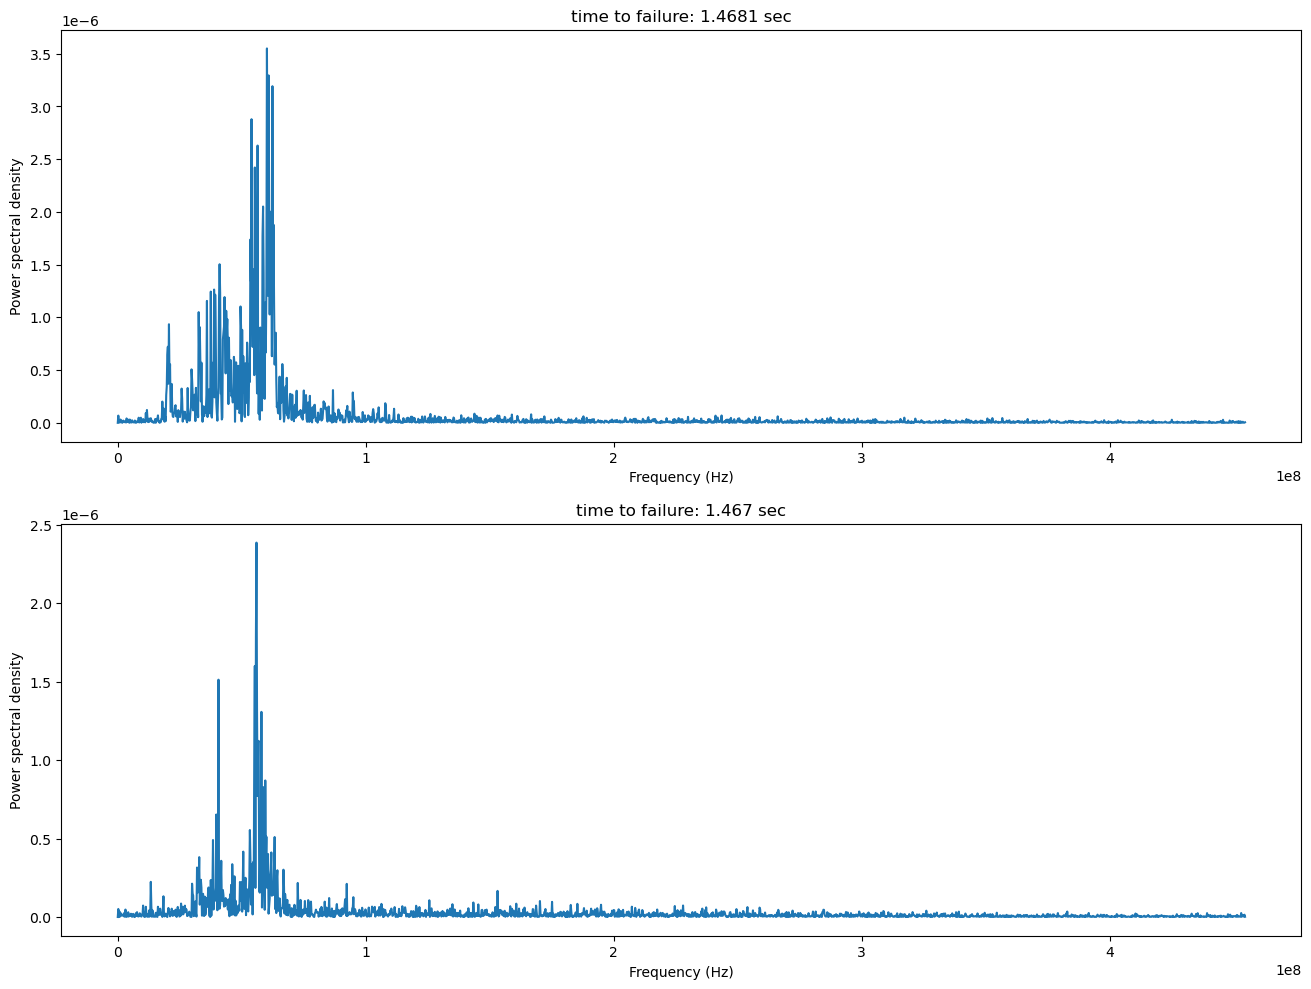

In [20]:
row1 = df_tr_sec['ttf_round'] == df_tr_sec['ttf_round'].unique()[1]
f1, Pxx_den1, f_dom1 = psd(df_tr_sec.loc[row1,'acoustic_data'])

row2 = df_tr_sec['ttf_round'] == df_tr_sec['ttf_round'].unique()[2]
f2, Pxx_den2, f_dom2 = psd(df_tr_sec.loc[row2,'acoustic_data'])

fig, ax_list = plt.subplots(2,1,figsize=(16, 12), dpi=100 )
ax = ax_list[0]
ax.plot(f1,Pxx_den1)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('time to failure: ' + df_tr_sec['ttf_round'].unique()[1] + ' sec' )

ax = ax_list[1]
ax.plot(f2,Pxx_den2)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency (Hz)')
ax.set_title('time to failure: ' + df_tr_sec['ttf_round'].unique()[2] + ' sec' );

The frequency component mainly distribute in 1e8 Hz. Divide this frequency interval to 10 pieces, calculate the probability to create some features

In [21]:
df_psd = df_tr_sec.groupby('ttf_round')['acoustic_data'].agg(psd)
df_psd = pd.DataFrame(df_psd.tolist(), index= df_psd.index, columns = ['freq', 'psd','f_dom'])
df_psd.head()

,freq,psd,f_dom
ttf_round,,,
1.4308,"[0.0, 357206.64404357923, 714413.2880871585, 1...","[2.4058242836791375e-39, 1.02954527591958e-07,...",5.71530630e+07
1.4319,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 1.5160343499452684e-07, 5.87705036998709...",6.01473722e+07
1.433,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 2.427974301821161e-07, 8.709172315991998...",5.70401278e+07
1.434,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 7.377340534178557e-08, 3.997906934969890...",3.86186080e+07
1.4351,"[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 1.8976395737071333e-08, 3.20879003980537...",6.99129972e+07


In [22]:
fsecs = ['f_sec' + str(num) for num in range(1,11)] # variable names
df_f = pd.DataFrame(columns = fsecs)
for index, row in df_psd.iterrows():
#     print(type(row))
    f_dict = dict()
    freq_sec = np.linspace(0,1e8,11)
    psd = row['psd']
    freq = row['freq']
    area = psd[freq < 1e8].sum()

    for idx, fsec in enumerate(fsecs):
        row_filter = (freq >= freq_sec[idx]) & (freq < freq_sec[idx+1])
        pzone = psd[row_filter].sum()    
        f_dict[fsec] = pzone / area
    temp = pd.DataFrame(f_dict,index =[index] )
#     print(temp)
    df_f = df_f.append(temp) 
df_psd = df_psd.merge(df_f, how = 'left', left_index = True, right_index = True)
df_psd.head().T

ttf_round,1.4308,1.4319,1.433,1.434,1.4351
freq,"[0.0, 357206.64404357923, 714413.2880871585, 1...","[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 221946.02272727274, 443892.04545454547, ...","[0.0, 221946.02272727274, 443892.04545454547, ..."
psd,"[2.4058242836791375e-39, 1.02954527591958e-07,...","[0.0, 1.5160343499452684e-07, 5.87705036998709...","[0.0, 2.427974301821161e-07, 8.709172315991998...","[0.0, 7.377340534178557e-08, 3.997906934969890...","[0.0, 1.8976395737071333e-08, 3.20879003980537..."
f_dom,57153063,60147372,57040128,38618608,69912997
f_sec1,0.018663116,0.011383158,0.014795234,0.010322085,0.048759826
f_sec2,0.03619608,0.014028674,0.020870639,0.029468356,0.071429379
f_sec3,0.056099068,0.042418963,0.069884057,0.070903322,0.095376687
f_sec4,0.10433925,0.078821207,0.10416894,0.18843071,0.10689126
f_sec5,0.16212579,0.14310953,0.1095054,0.15071376,0.16753724
f_sec6,0.36710466,0.39284,0.43727298,0.273352,0.11055486
f_sec7,0.11509893,0.22097272,0.131849,0.13893969,0.14391569


merge time-lag features `df_lag_all` with frequency-domain features `df_psd`

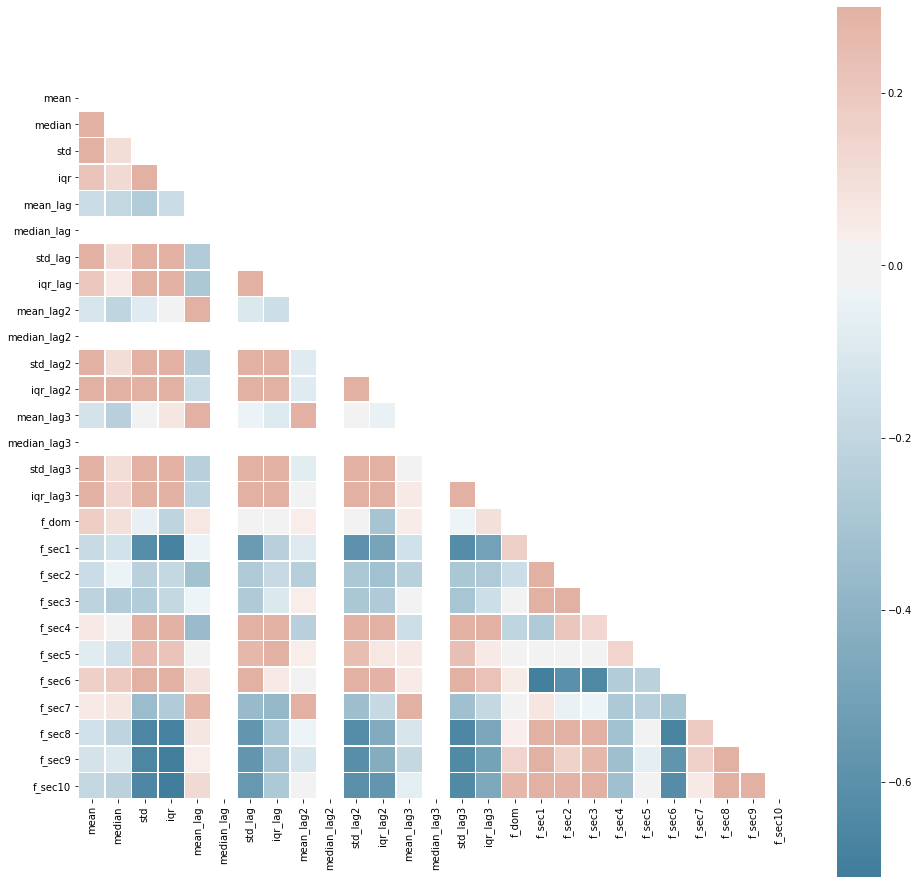

In [23]:
df_agg_all = df_lag_all.merge(df_psd, how = 'left', left_index = True, right_index = True)
# df_agg_all.reset_index(inplace = True)
# df_agg_all.ttf_round = df_agg_all.ttf_round.astype('float')

corr_lag = df_agg_all.corr()
mask = np.triu(np.ones_like(corr_lag, dtype=bool))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
f, ax = plt.subplots(figsize=(16, 16))
ax = sns.heatmap(corr_lag, mask=mask, cmap=cmap, vmax=.3, center=0,
                 square=True, linewidths=.5);

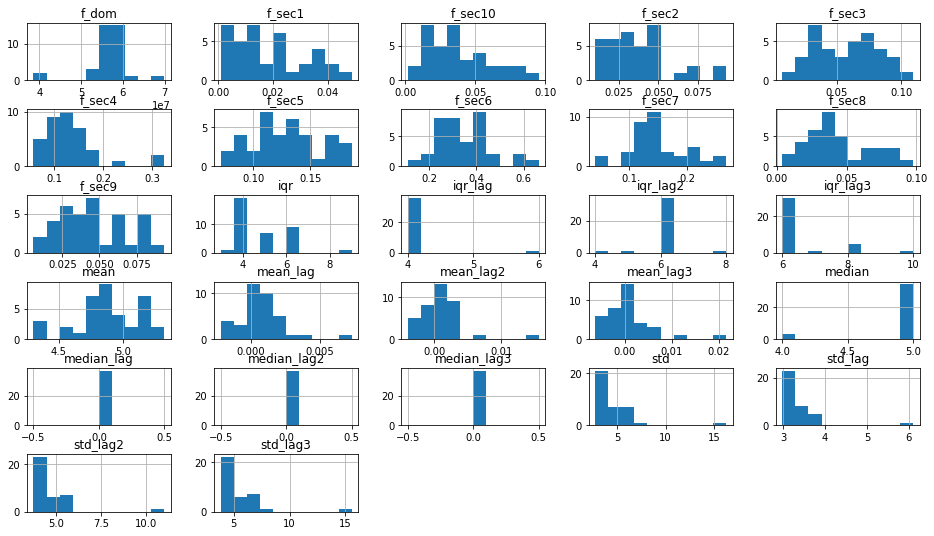

In [24]:
df_agg_all.hist(figsize=(16,9))
plt.subplots_adjust(hspace=0.5);

Q: why median and iqr only have a precision of 1

Because `acoustic_data` is int type.

## 2.5.3 Truncate training data for each earthquake event

In [ ]:
# using chunk to manipulate the raw train data
filenum = 0
j = 0
previous_df = pd.DataFrame()
total_missing = np.array([0,0])
total_records = 0
min_time = 100000

for chunk in pd.read_csv(filename, chunksize = 1e7):
    # count missing value in each column

    total_missing += chunk.isna().sum().to_numpy()
    total_records += len(chunk)
    min_time = np.array([chunk.iloc[-1,1], min_time]).min()
    
    j += 1
#     print('chunk', j)
    dt_df = chunk[['time_to_failure']].shift(fill_value = chunk.iloc[0]['time_to_failure']) - chunk[['time_to_failure']]
    # find the last index of an earthquake event
    idx = dt_df[dt_df['time_to_failure'] < 0].index
    
    if len(idx) == 0:
        previous_df = pd.concat([previous_df,chunk])
    else:
        prev_i = chunk.index[0]
#         print('idx', idx)
        for i in idx:
            # save each earthquake event in a pickle file
            pd.concat([previous_df, chunk.loc[prev_i:i, :]]).to_pickle('D:/DataScience/traindata/train_sec_' + str(filenum) + '.pkl')
            filenum += 1
            prev_i = i
        previous_df = chunk.loc[i:, :]
#     print('filename', filenum)

# The last earthquake file    
previous_df.to_pickle('D:/DataScience/traindata/train_sec_' + str(filenum) + '.pkl')

In [ ]:
print("nan for two variables: ", total_missing)
print("Total records: ", total_records)
print("Last time of recording: ", min_time)

## 2.5.4 Check tuncated data

In [ ]:
def plot_train_segment(fileobject):
    df = pd.read_pickle(fileobject)
    print(df.columns)
    print('Records number:',len(df))
    df.plot(x = 'time_to_failure', y = 'acoustic_data')
    
    plt.gca().invert_xaxis()
    plt.title(fileobject[31:-4])
    plt.savefig("../images/" + fileobject[25:-4] + ".jpg")
    #     plt.close()

In [ ]:
pathlist = ['D:/DataScience/traindata/train_sec_' + str(num) + '.pkl' for num in range (0,17)]


In [ ]:
# plot the training segment and save figure
for path in pathlist[4:6]:
    plot_train_segment(path)

In [ ]:
df_tr_end = pd.read_pickle(pathlist[-1])
df_tr_end.iloc[-5:]

`train_sec_16` is not complete, i.e., it does not records the failure event

## 2.5.5 Pandas profiling for a training segment

In [ ]:
df_tr_sec = pd.read_pickle(pathlist[7])

In [ ]:
profile = ProfileReport(df_tr_sec, title="Pandas Profiling Report of the Training Data 6")

In [ ]:
# profile.to_widgets()

In [ ]:
profile.to_file("../report/training_data_report_6.html")

# 2.6 Load the testing data

In [ ]:
testfilepath = "../raw_data/test/"
os.chdir(testfilepath)
testfiles = glob.glob("*.csv")
print(testfiles[0:5])

In [ ]:
def plot_test_file(fileobject):
    df = pd.read_csv(fileobject)
    print(df.describe())
    df.plot(y = 'acoustic_data')
    plt.title(fileobject[0:-4])

In [ ]:
df_te = pd.read_csv(testfiles[0])
df_te.head()

In [ ]:
for testfile in testfiles[0:3]:
    print(len(testfile))
    plot_test_file(testfile)
    

# 2.7 Summary

For the training data:
* The data has zero missing values for both columns
* The data has only two column ,`acoustic_data` in int type and `time_to_failure` in float type. `time_to_failure` is our target.
* The data has 629,145,480 records, too large to operate.
* `acoustic_data` is the acoustic emission signal (amplitude), consisting of many peaks and troughts. 
* `time_to_failure` decreases from a value to zero periodically. The data should be truncated based on it.
* 17 segments were obtained after analyzing chunk data in the rawdata. 
* Each training segment has different time length
* The first one only has about two seconds record to earthquake. The last one is not complete because the `time_to_failure` is 9.75 s, far from zero.
* After `acoustic_data` reaches a extremly large event, the eqrthquake occurs soon in each training segment, and `time_to_failure` is less than 0.5s.

For the testing data:
* Only one row in each file, which is the `acoustic_data`
* Each segment contains 150k records, a small segment from a complete earthquake event. By comparision, records in training data is about 200 times of the test data. This may inspire us the feature extraction from the training data
* Similar to the training data, the average `acoustic_data` of a test data are small, while some abnormal `acoustic_data` exists. These determines what a feature is.
* Most test data may not contain the extremly large event with an absolute of amplitude over 1000. They contains peaks at a scale of several hundred amplitude

7/11/2022
For the training data:

* Resampling using groupby on round precision = 4 for `time_to_failure`
* Time lagging is tried on `acoustic_data` to create features. However, what time step is an optimum value?